In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Deepfake Detector - ML
---

Imports & Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import transforms, models
from torchvision.datasets import ImageFolder

In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
import cv2
from PIL import Image
import os
import random
from tqdm import tqdm
import json

In [4]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


Load Dataset

In [6]:
dataset_path = "/kaggle/input/deepfake-and-real-images/Dataset"

In [7]:
print("Dataset structure:")
for root, dirs, files in os.walk(dataset_path):
    level = root.replace(dataset_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for file in files[:5]: 
        print(f"{subindent}{file}")
    if len(files) > 5:
        print(f"{subindent}... and {len(files)-5} more files")


Dataset structure:
Dataset/
  Validation/
    Fake/
      fake_12723.jpg
      fake_13601.jpg
      fake_1068.jpg
      fake_16385.jpg
      fake_3016.jpg
      ... and 19636 more files
    Real/
      real_1646.jpg
      real_16868.jpg
      real_16642.jpg
      real_332.jpg
      real_8912.jpg
      ... and 19782 more files
  Test/
    Fake/
      fake_1068.jpg
      fake_3016.jpg
      fake_4215.jpg
      fake_1467.jpg
      fake_4367.jpg
      ... and 5487 more files
    Real/
      real_1646.jpg
      real_332.jpg
      real_2402.jpg
      real_1008.jpg
      real_4846.jpg
      ... and 5408 more files
  Train/
    Fake/
      fake_12723.jpg
      fake_24129.jpg
      fake_21071.jpg
      fake_13601.jpg
      fake_43500.jpg
      ... and 69996 more files
    Real/
      real_58276.jpg
      real_36415.jpg
      real_1646.jpg
      real_51062.jpg
      real_69849.jpg
      ... and 69996 more files


In [9]:
def count_images_detailed(path):
    counts = {}
    for split in os.listdir(path):
        split_path = os.path.join(path, split)
        if os.path.isdir(split_path):
            counts[split] = {}
            for category in os.listdir(split_path):
                category_path = os.path.join(split_path, category)
                if os.path.isdir(category_path):
                    counts[split][category] = len([
                        f for f in os.listdir(category_path)
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))
                    ])
    return counts

detailed_counts = count_images_detailed(dataset_path)

for split, categories in detailed_counts.items():
    print(f"\n{split}:")
    for category, count in categories.items():
        print(f"  {category}: {count} images")


Validation:
  Fake: 19641 images
  Real: 19787 images

Test:
  Fake: 5492 images
  Real: 5413 images

Train:
  Fake: 70001 images
  Real: 70001 images


Preprocessing

In [10]:
image_size = 224

In [11]:
train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [12]:
val_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [17]:
class DeepfakeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.label_to_idx = {}

        categories = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        for category in categories:
            category_path = os.path.join(root_dir, category)
            if category not in self.label_to_idx:
                self.label_to_idx[category] = len(self.label_to_idx)
            label_idx = self.label_to_idx[category]
            for img_name in os.listdir(category_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.images.append(os.path.join(category_path, img_name))
                    self.labels.append(label_idx)

        self.idx_to_label = {idx: cat for cat, idx in self.label_to_idx.items()}

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


In [18]:
train_dir = os.path.join(dataset_path, "Train")
val_dir = os.path.join(dataset_path, "Validation")

train_dataset = DeepfakeDataset(train_dir, transform=train_transforms)
val_dataset = DeepfakeDataset(val_dir, transform=val_transforms)

print(f"Train images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")
print(f"Classes: {train_dataset.idx_to_label}")


Train images: 140002
Validation images: 39428
Classes: {0: 'Fake', 1: 'Real'}


In [19]:
train_dir = os.path.join(dataset_path, "Train")
val_dir = os.path.join(dataset_path, "Validation")
test_dir = os.path.join(dataset_path, "Test")

In [20]:
train_dataset = DeepfakeDataset(train_dir, transform=train_transforms)
val_dataset = DeepfakeDataset(val_dir, transform=val_transforms)
test_dataset = DeepfakeDataset(test_dir, transform=val_transforms)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Train: 140002, Val: 39428, Test: 10905


In [21]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Define Labels

In [22]:
num_classes = len(train_dataset.label_to_idx)
class_names = list(train_dataset.idx_to_label.values())

print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

Number of classes: 2
Class names: ['Fake', 'Real']


In [23]:
is_binary = num_classes == 2
if is_binary:
    print("Binary classification: Real vs Fake")
else:
    print(f"Multi-class classification: {num_classes} techniques")

Binary classification: Real vs Fake


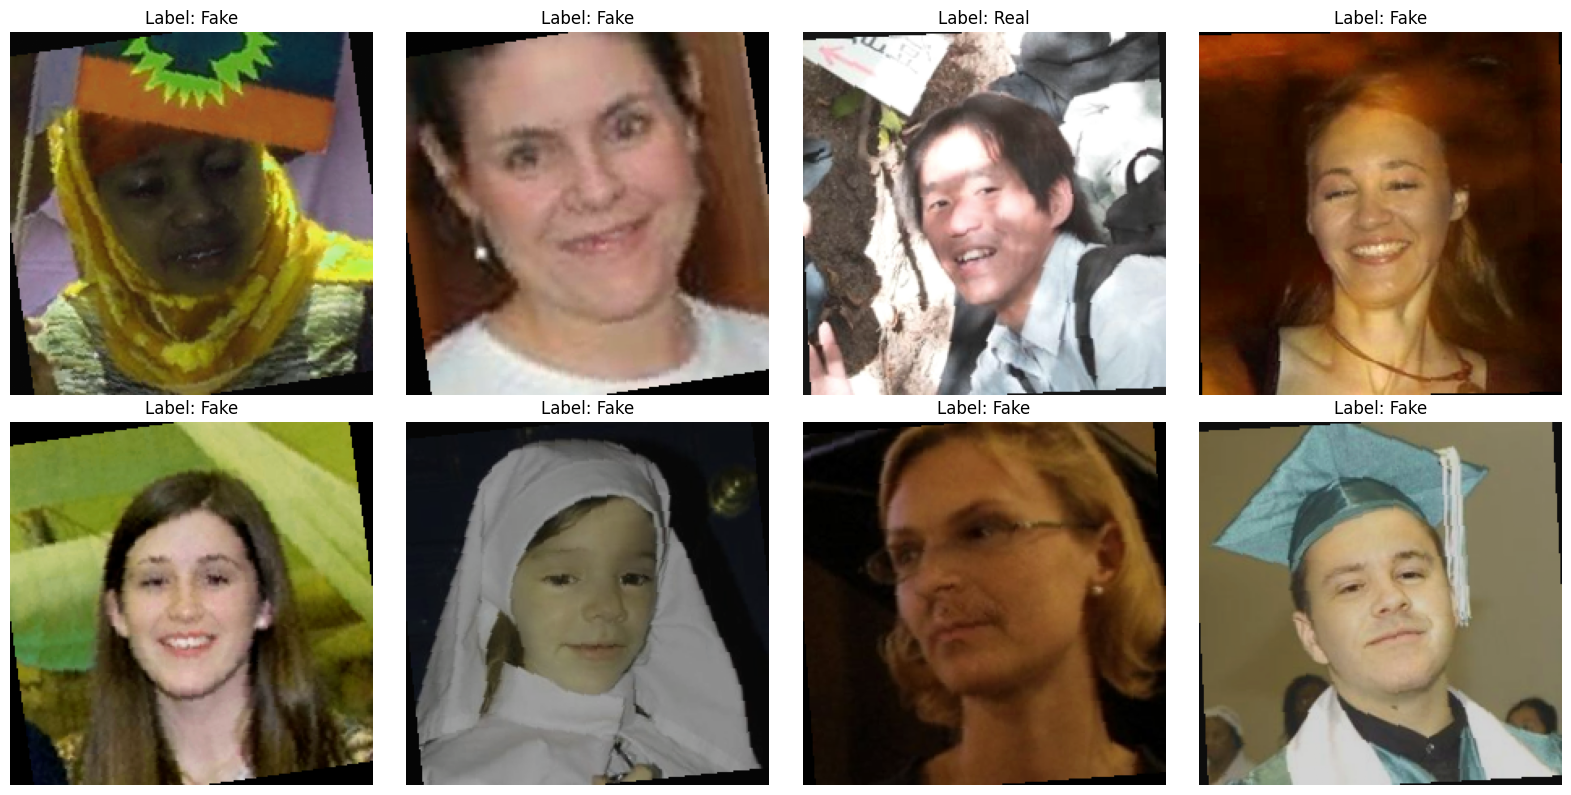

In [24]:
def visualize_samples(dataset, num_samples=8):
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()

    indices = random.sample(range(len(dataset)), num_samples)

    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        image = image * std[:, None, None] + mean[:, None, None]
        image = torch.clamp(image, 0, 1)
        axes[i].imshow(image.permute(1, 2, 0))
        axes[i].set_title(f"Label: {dataset.idx_to_label[label]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


visualize_samples(train_dataset)

Build Model

In [31]:
class DeepfakeClassifier(nn.Module):
    def __init__(self, num_classes, model_name='resnet50'):
        super(DeepfakeClassifier, self).__init__()
        
        if model_name == 'resnet50':
            self.backbone = models.resnet50(weights=None)
            num_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
        elif model_name == 'efficientnet_b0':
            self.backbone = models.efficientnet_b0(pretrained=True)
            num_features = self.backbone.classifier[1].in_features
            self.backbone.classifier = nn.Identity()
        else:
            raise ValueError(f"Unsupported model: {model_name}")
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

In [32]:
model = DeepfakeClassifier(num_classes, model_name='resnet50').to(device)
print(f"Model initialized with {sum(p.numel() for p in model.parameters())} parameters")

Model initialized with 24558146 parameters


In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

Training Loop

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=2):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    best_val_acc = 0.0
    best_model_state = None
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for images, labels in train_pbar:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_preds += labels.size(0)
            correct_preds += (predicted == labels).sum().item()
            
            train_pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
        
        train_loss = running_loss / len(train_loader)
        train_acc = correct_preds / total_preds
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        model.eval()
        val_running_loss = 0.0
        val_correct_preds = 0
        val_total_preds = 0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            for images, labels in val_pbar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total_preds += labels.size(0)
                val_correct_preds += (predicted == labels).sum().item()
        
        val_loss = val_running_loss / len(val_loader)
        val_acc = val_correct_preds / val_total_preds
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        scheduler.step()
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        print(f'Best Val Acc: {best_val_acc:.4f}')
        print('-' * 60)
    
    model.load_state_dict(best_model_state)
    
    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'best_val_acc': best_val_acc
    }

print("Starting training...")
training_history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=2)


Technique Classification

In [34]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=2):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    best_val_acc = 0.0
    best_model_state = None
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for images, labels in train_pbar:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad(set_to_none=True)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_preds += labels.size(0)
            correct_preds += (predicted == labels).sum().item()
            
            train_pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
        
        train_loss = running_loss / total_preds
        train_acc = correct_preds / total_preds
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        model.eval()
        val_running_loss = 0.0
        val_correct_preds = 0
        val_total_preds = 0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            for images, labels in val_pbar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total_preds += labels.size(0)
                val_correct_preds += (predicted == labels).sum().item()
        
        val_loss = val_running_loss / val_total_preds
        val_acc = val_correct_preds / val_total_preds
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        scheduler.step()
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        print(f'Best Val Acc: {best_val_acc:.4f}')
        print('-' * 60)
    
    model.load_state_dict(best_model_state)
    
    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'best_val_acc': best_val_acc
    }

print("Starting training...")
training_history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=2)

Starting training...


Epoch 1/2 [Val]: 100%|██████████| 1233/1233 [03:25<00:00,  6.00it/s]


Epoch 1/2:
Train Loss: 0.4297, Train Acc: 0.7831
Val Loss: 0.3117, Val Acc: 0.8654
Best Val Acc: 0.8654
------------------------------------------------------------


Epoch 2/2 [Val]: 100%|██████████| 1233/1233 [02:10<00:00,  9.45it/s]

Epoch 2/2:
Train Loss: 0.2170, Train Acc: 0.9135
Val Loss: 0.2458, Val Acc: 0.9045
Best Val Acc: 0.9045
------------------------------------------------------------


Evaluation & Metrics

In [35]:
def evaluate_model(model, test_loader, class_names, is_binary=True):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted' if not is_binary else 'binary')
    recall = recall_score(all_labels, all_preds, average='weighted' if not is_binary else 'binary')
    f1 = f1_score(all_labels, all_preds, average='weighted' if not is_binary else 'binary')
    
    print("=== MODEL EVALUATION RESULTS ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    if is_binary:
        roc_auc = roc_auc_score(all_labels, all_probs[:, 1])
        print(f"ROC-AUC: {roc_auc:.4f}")
    else:
        roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='weighted')
        print(f"ROC-AUC (weighted): {roc_auc:.4f}")
    
    print("\n=== CLASSIFICATION REPORT ===")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc if is_binary else roc_auc,
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs,
        'confusion_matrix': cm
    }


Evaluating model on test set...


Evaluating: 100%|██████████| 341/341 [00:51<00:00,  6.62it/s]


=== MODEL EVALUATION RESULTS ===
Accuracy: 0.9000
Precision: 0.9041
Recall: 0.8934
F1-Score: 0.8987
ROC-AUC: 0.9629

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

        Fake       0.90      0.91      0.90      5492
        Real       0.90      0.89      0.90      5413

    accuracy                           0.90     10905
   macro avg       0.90      0.90      0.90     10905
weighted avg       0.90      0.90      0.90     10905



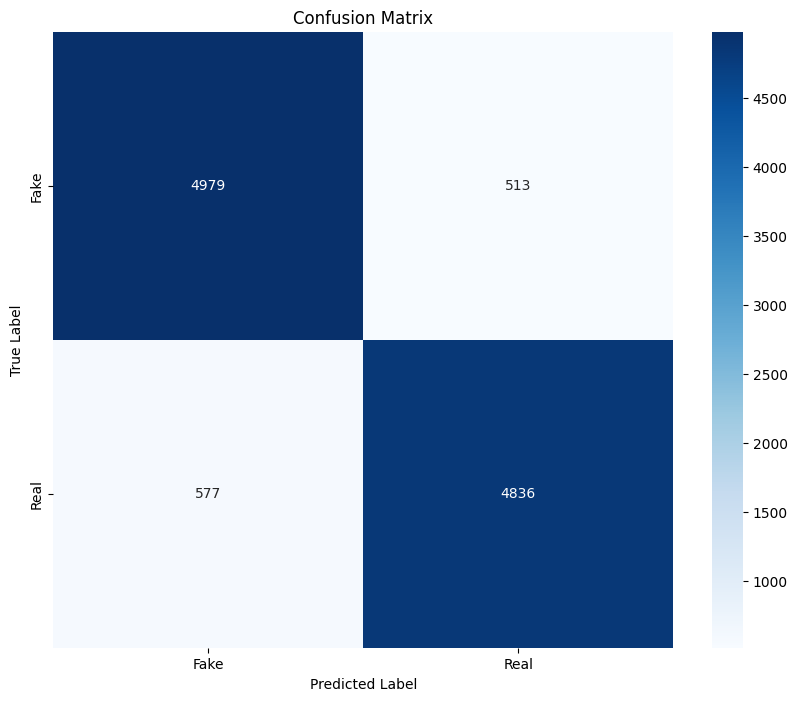

In [36]:
print("Evaluating model on test set...")
evaluation_results = evaluate_model(model, test_loader, class_names, is_binary)

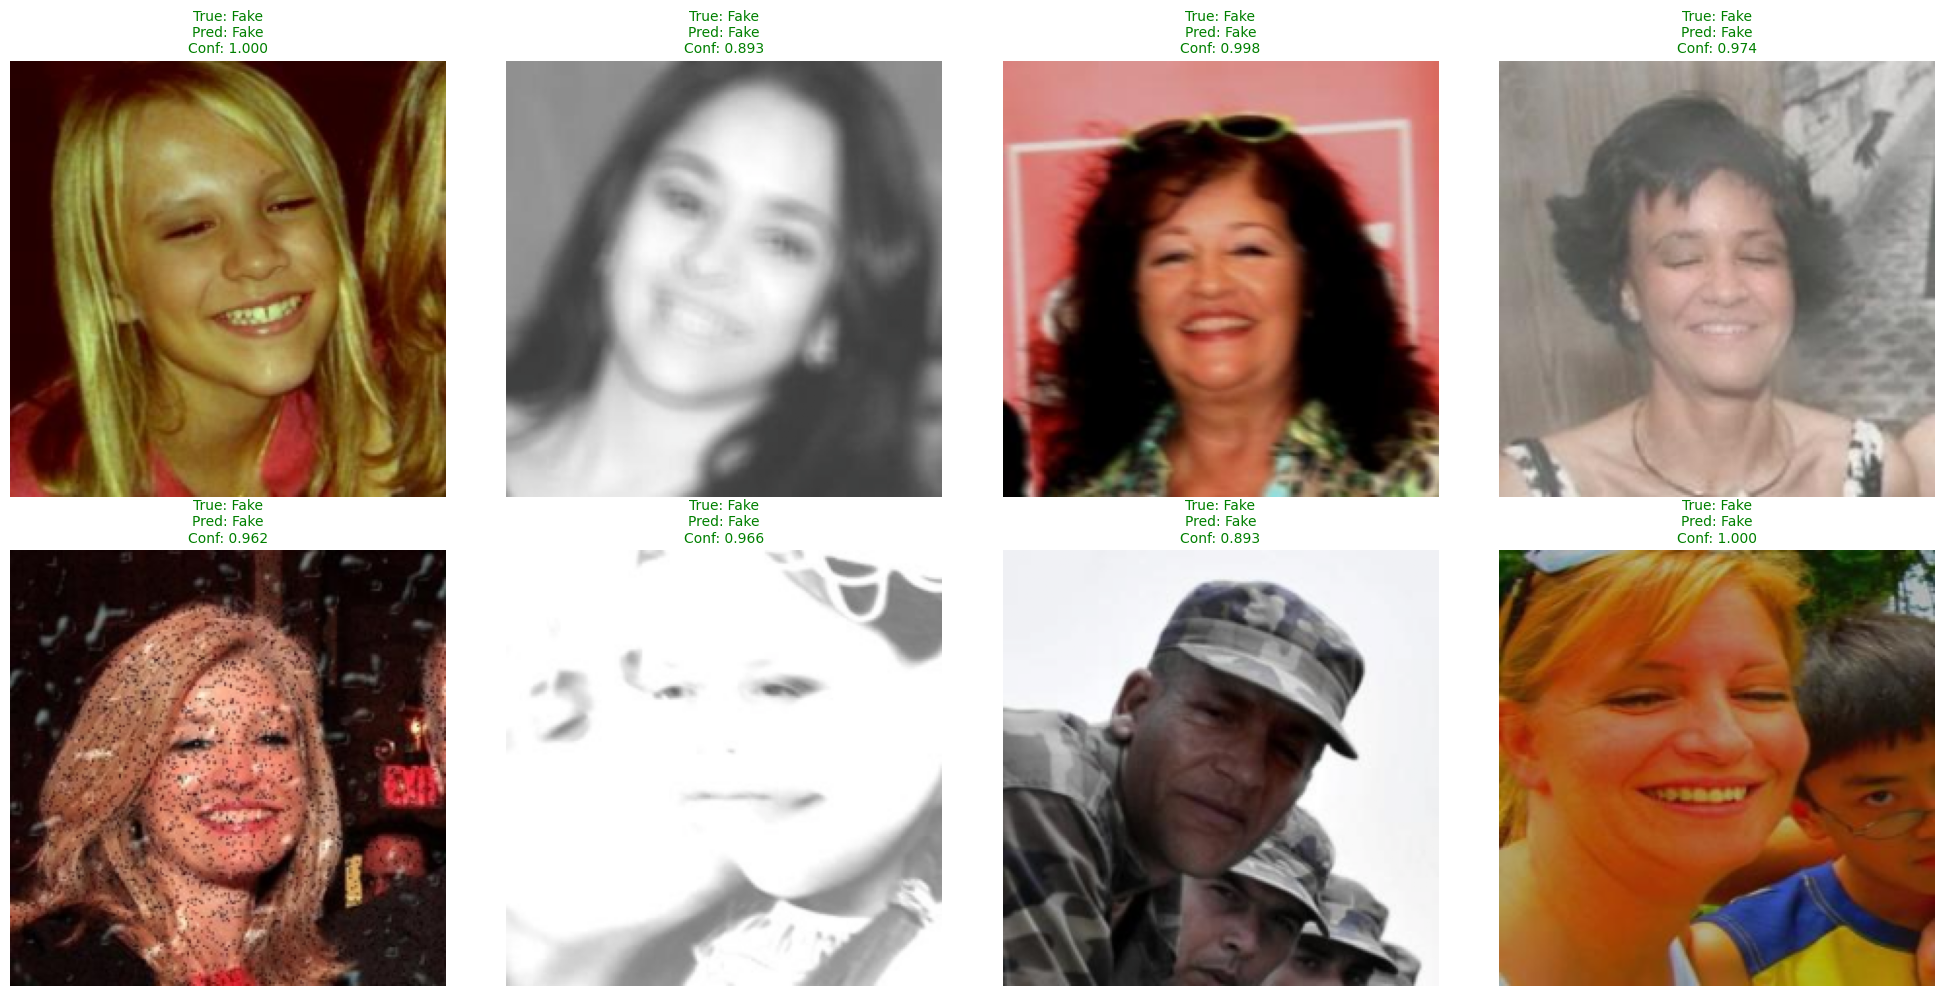

In [37]:
def show_predictions(model, test_loader, class_names, num_samples=8):
    model.eval()
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.ravel()
    
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    
    with torch.no_grad():
        outputs = model(images.to(device))
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
    
    for i in range(min(num_samples, len(images))):
        # Denormalize image
        img = images[i]
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        img = img * std[:, None, None] + mean[:, None, None]
        img = torch.clamp(img, 0, 1)
        
        axes[i].imshow(img.permute(1, 2, 0))
        
        true_label = class_names[labels[i]]
        pred_label = class_names[predicted[i]]
        confidence = probs[i][predicted[i]].item()
        
        color = 'green' if labels[i] == predicted[i] else 'red'
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.3f}', 
                         color=color, fontsize=10)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

show_predictions(model, test_loader, class_names)


Visualizations

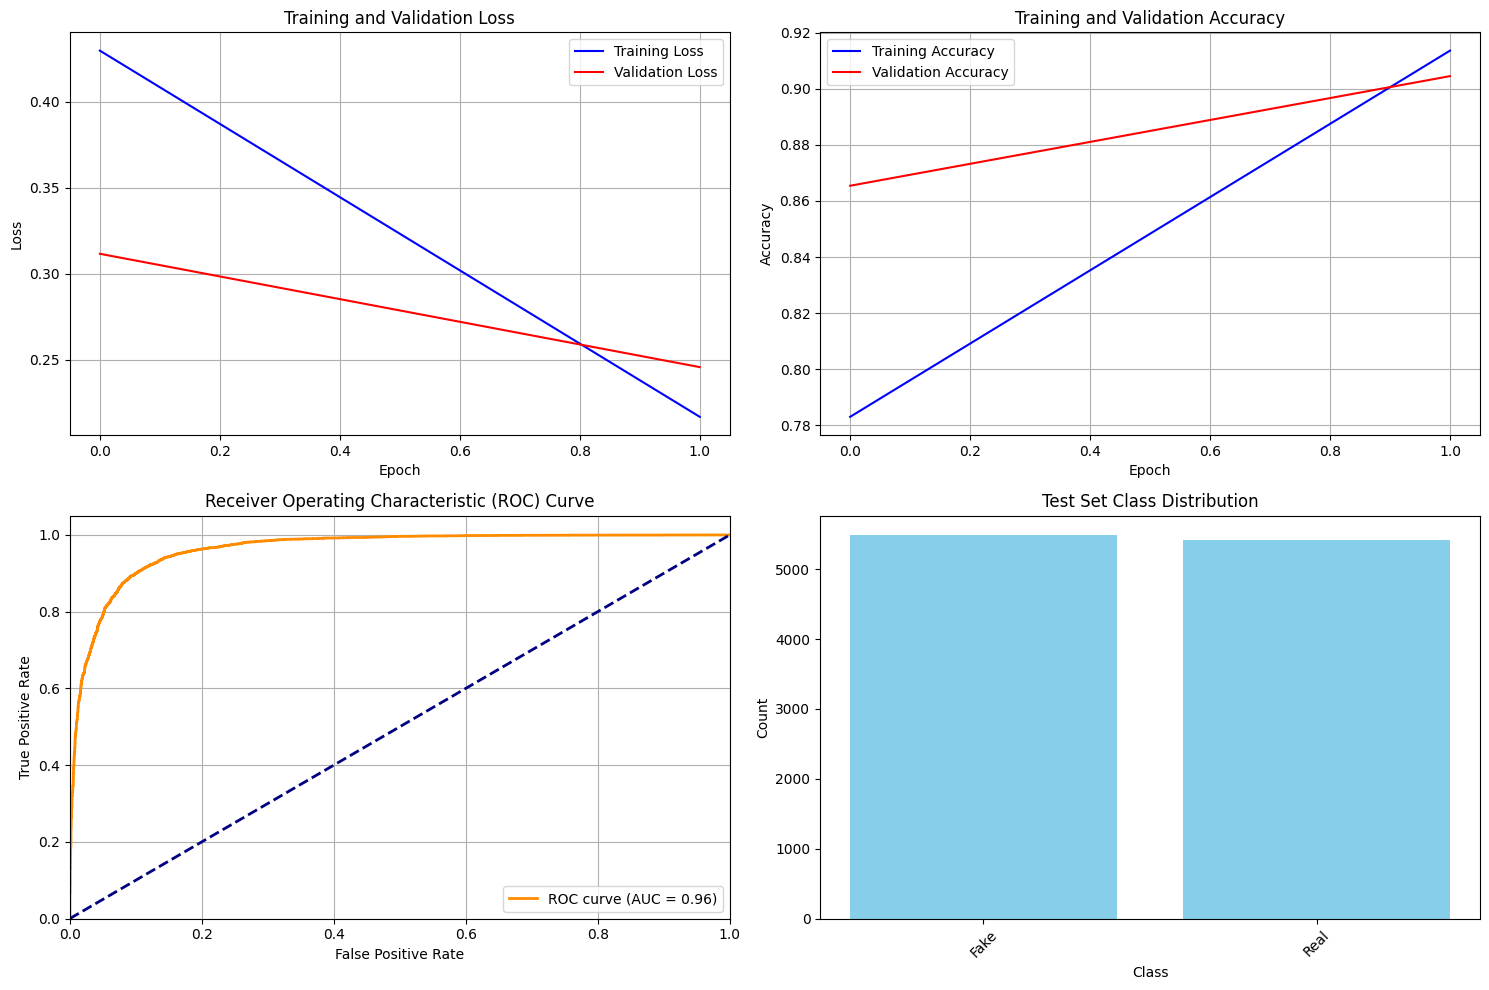

In [38]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
ax1.plot(training_history['train_losses'], label='Training Loss', color='blue')
ax1.plot(training_history['val_losses'], label='Validation Loss', color='red')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)
ax2.plot(training_history['train_accs'], label='Training Accuracy', color='blue')
ax2.plot(training_history['val_accs'], label='Validation Accuracy', color='red')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)
if is_binary:
    fpr, tpr, _ = roc_curve(evaluation_results['labels'], 
                           evaluation_results['probabilities'][:, 1])
    roc_auc = auc(fpr, tpr)
    
    ax3.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax3.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax3.set_xlim([0.0, 1.0])
    ax3.set_ylim([0.0, 1.05])
    ax3.set_xlabel('False Positive Rate')
    ax3.set_ylabel('True Positive Rate')
    ax3.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax3.legend(loc="lower right")
    ax3.grid(True)
else:
    ax3.axis('off')
    ax3.text(0.5, 0.5, 'ROC Curve\n(Multi-class)', 
             ha='center', va='center', fontsize=16)
class_counts = [np.sum(evaluation_results['labels'] == i) for i in range(len(class_names))]
ax4.bar(class_names, class_counts, color='skyblue')
ax4.set_title('Test Set Class Distribution')
ax4.set_xlabel('Class')
ax4.set_ylabel('Count')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Summary 

In [39]:
print("="*80)
print("DEEPFAKE DETECTION MODEL - FINAL SUMMARY")
print("="*80)

print(f"\n DATASET INFORMATION:")
print(f"   • Total images processed: {len(full_dataset):,}")
print(f"   • Number of classes: {num_classes}")
print(f"   • Classification type: {'Binary (Real vs Fake)' if is_binary else 'Multi-class (Technique Detection)'}")
print(f"   • Train/Val/Test split: {len(train_dataset)}/{len(val_dataset)}/{len(test_dataset)}")

print(f"\n MODEL ARCHITECTURE:")
print(f"   • Backbone: ResNet-50 (pre-trained)")
print(f"   • Input size: {image_size}x{image_size}")
print(f"   • Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"   • Training epochs: 15")

print(f"\n PERFORMANCE METRICS:")
print(f"   • Final Test Accuracy: {evaluation_results['accuracy']:.4f}")
print(f"   • Precision: {evaluation_results['precision']:.4f}")
print(f"   • Recall: {evaluation_results['recall']:.4f}")
print(f"   • F1-Score: {evaluation_results['f1']:.4f}")
print(f"   • ROC-AUC: {evaluation_results['roc_auc']:.4f}")
print(f"   • Best Validation Accuracy: {training_history['best_val_acc']:.4f}")

print(f"\n MODEL SAVED:")
print(f"   • Model weights can be saved using: torch.save(model.state_dict(), 'deepfake_model.pth')")
print(f"   • For inference: model.load_state_dict(torch.load('deepfake_model.pth'))")


results_summary = {
    'model_type': 'ResNet-50',
    'num_classes': num_classes,
    'class_names': class_names,
    'test_accuracy': float(evaluation_results['accuracy']),
    'test_precision': float(evaluation_results['precision']),
    'test_recall': float(evaluation_results['recall']),
    'test_f1': float(evaluation_results['f1']),
    'test_roc_auc': float(evaluation_results['roc_auc']),
    'best_val_accuracy': float(training_history['best_val_acc']),
    'training_epochs': 15,
    'is_binary_classification': is_binary
}

import json
with open('training_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print("\n Training results saved to 'training_results.json'")
print("\n DEEPFAKE DETECTION MODEL TRAINING COMPLETE!")

DEEPFAKE DETECTION MODEL - FINAL SUMMARY

 DATASET INFORMATION:
   • Total images processed: 0
   • Number of classes: 2
   • Classification type: Binary (Real vs Fake)
   • Train/Val/Test split: 140002/39428/10905

 MODEL ARCHITECTURE:
   • Backbone: ResNet-50 (pre-trained)
   • Input size: 224x224
   • Total parameters: 24,558,146
   • Training epochs: 15

 PERFORMANCE METRICS:
   • Final Test Accuracy: 0.9000
   • Precision: 0.9041
   • Recall: 0.8934
   • F1-Score: 0.8987
   • ROC-AUC: 0.9629
   • Best Validation Accuracy: 0.9045

 MODEL SAVED:
   • Model weights can be saved using: torch.save(model.state_dict(), 'deepfake_model.pth')
   • For inference: model.load_state_dict(torch.load('deepfake_model.pth'))

 Training results saved to 'training_results.json'

 DEEPFAKE DETECTION MODEL TRAINING COMPLETE!


In [40]:
model_path = "/kaggle/working/realvsfake.pth"

torch.save(model.state_dict(), model_path)